# Импорты и константы (seed)

In [5]:
import re
import random

###

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

###

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

###


from gensim.models import KeyedVectors


In [6]:
SEED = 38

# Зачем вообще нужны нейросети?

# Небольшой рекап
Источник [1]

Будем говорить о **полносвязных** нейронных сетях. Минимальная ее вычислительная единица -- это **нейрон**. Он принимает на вход вектор вещественных значений и выдает некоторое вещественное же число.

$\begin{align}
f = \sigma(Wx+b)
\end{align}
$
Где:  $\begin{align}
Wx = \sum_{i=0}^n w_i * x_i 
\end{align}$

![Pasted image 20240712160021.png](<attachment:Pasted image 20240712160021.png>)
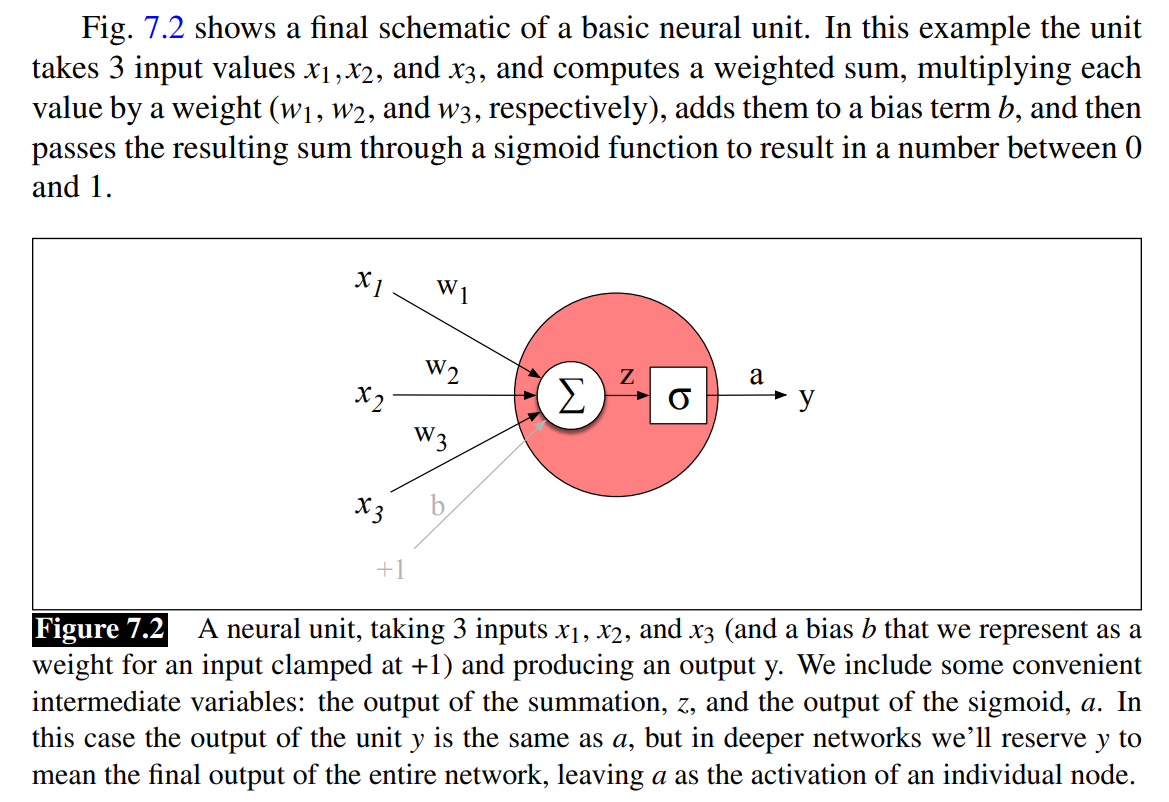

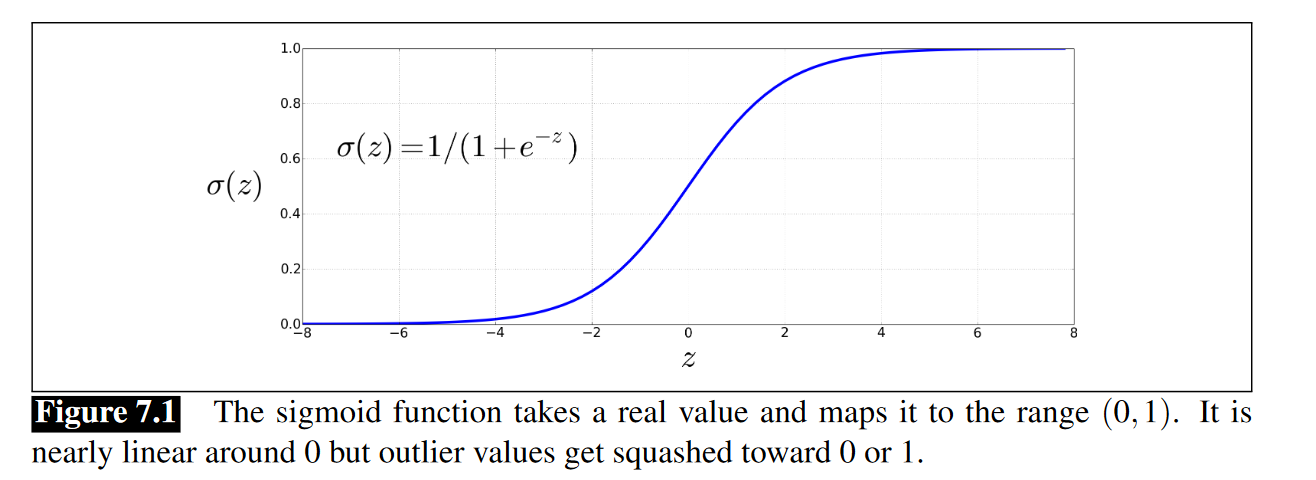

![Pasted image 20240712160114.png](<attachment:Pasted image 20240712160114.png>)
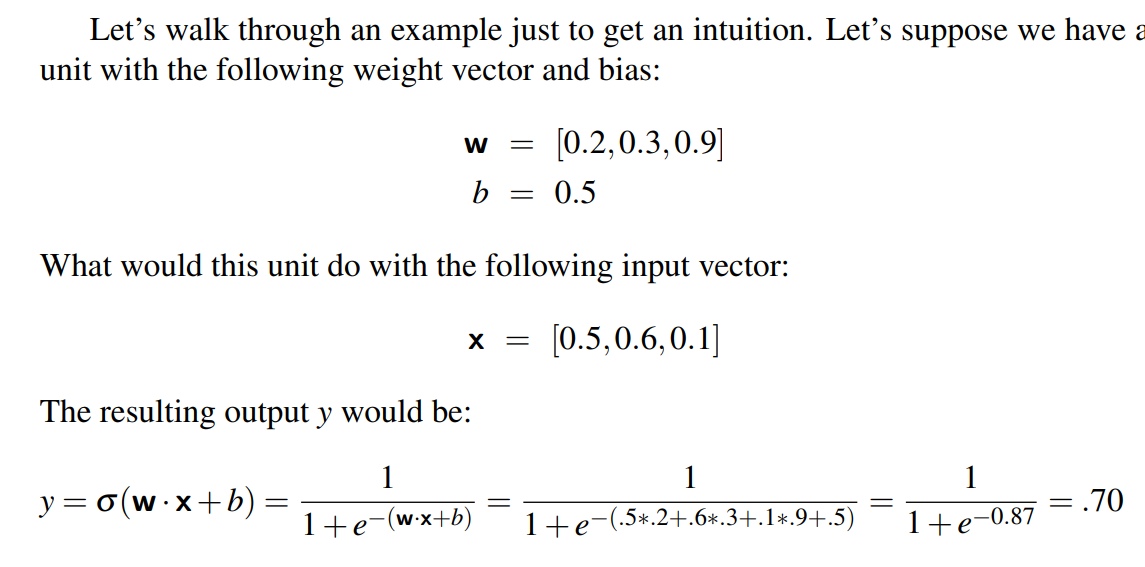

Как можно заметить, нейрон -- сам себе **линейный** классификатор.

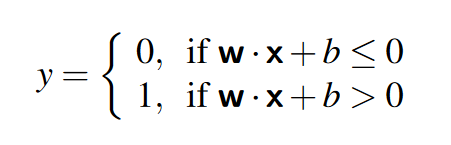

Для сравнения, уравнение гиперплоскости: $\begin{align}{\displaystyle n_{1}x_{1}+n_{2}x_{2}+\ldots +n_{k}x_{k}=d}\end{align}$

То есть мы ограничены линейностью модели.


#### Посмотрим на такую задачу:
\*XOR - взаимоисключающее OR
![Pasted image 20240712162005.png](<attachment:Pasted image 20240712162005.png>)
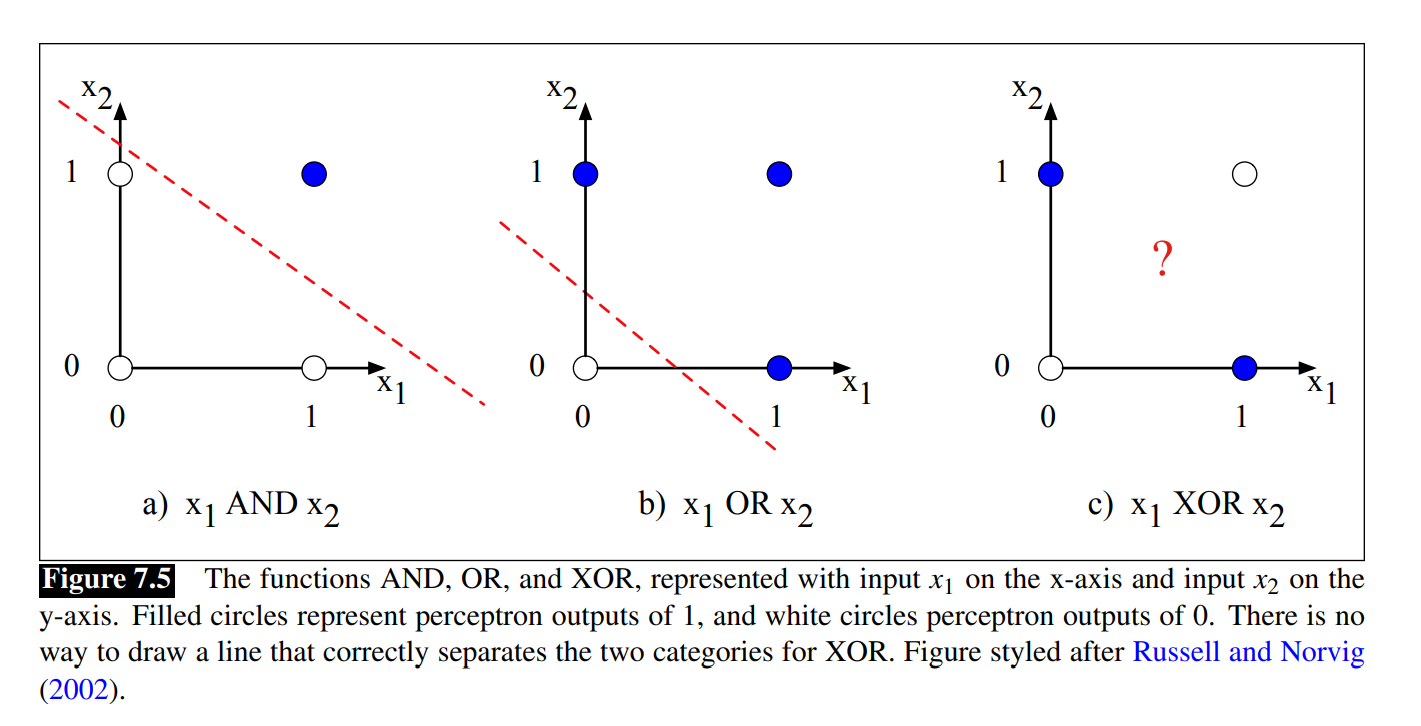

Примеры логических функций, выраженных нейросетями: 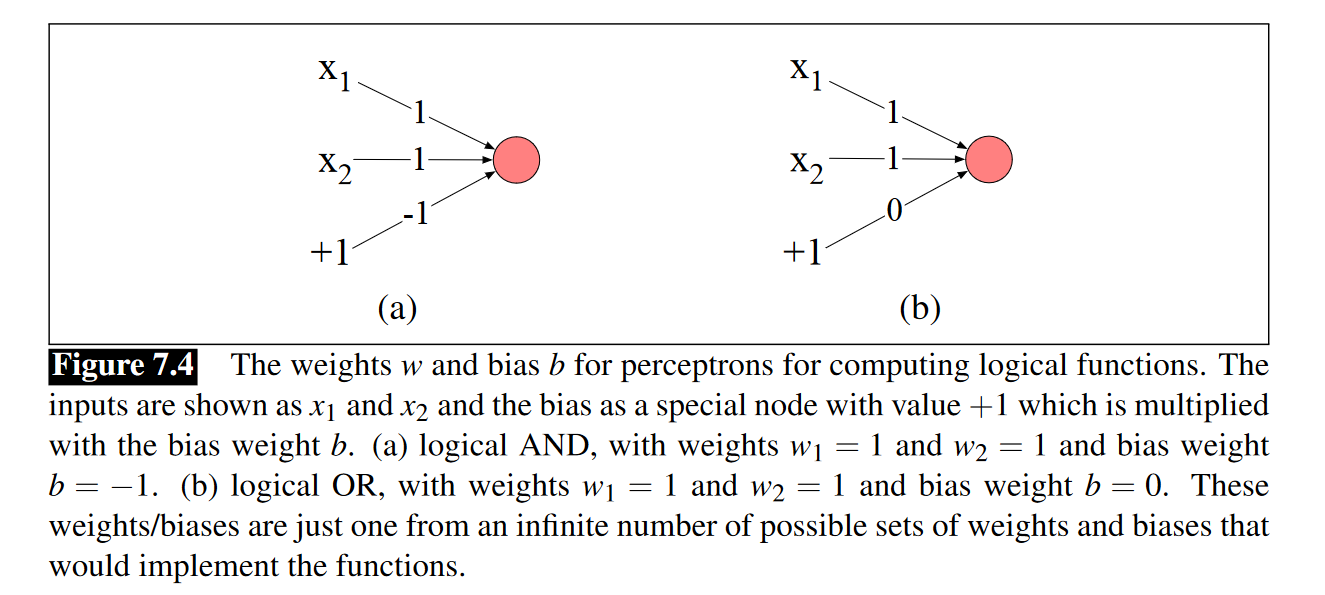

Теперь, что будет, если мы составим нейросеть для XOR "руками":

Функция активации: ReLU (Rectified Linear Unit) $\begin{align}ReLU = max(0, x)\end{align}$

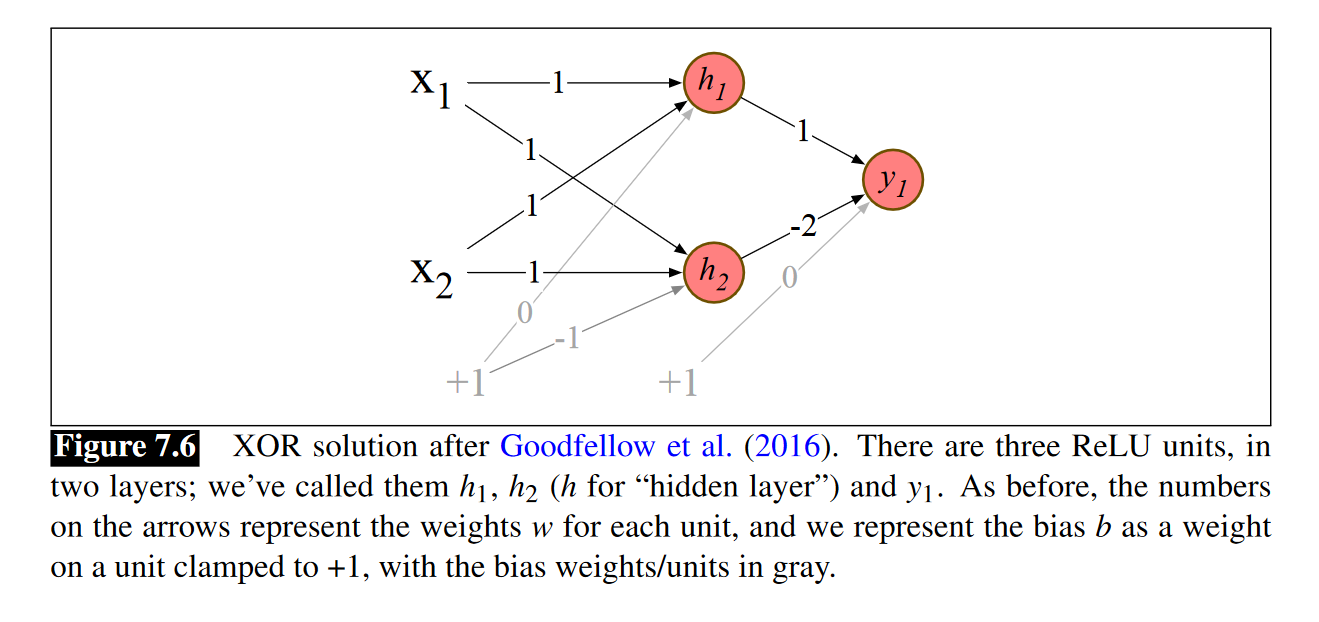

Новое пространство признаков для скрытого слоя:

![Pasted image 20240712162437.png](<attachment:Pasted image 20240712162437.png>)
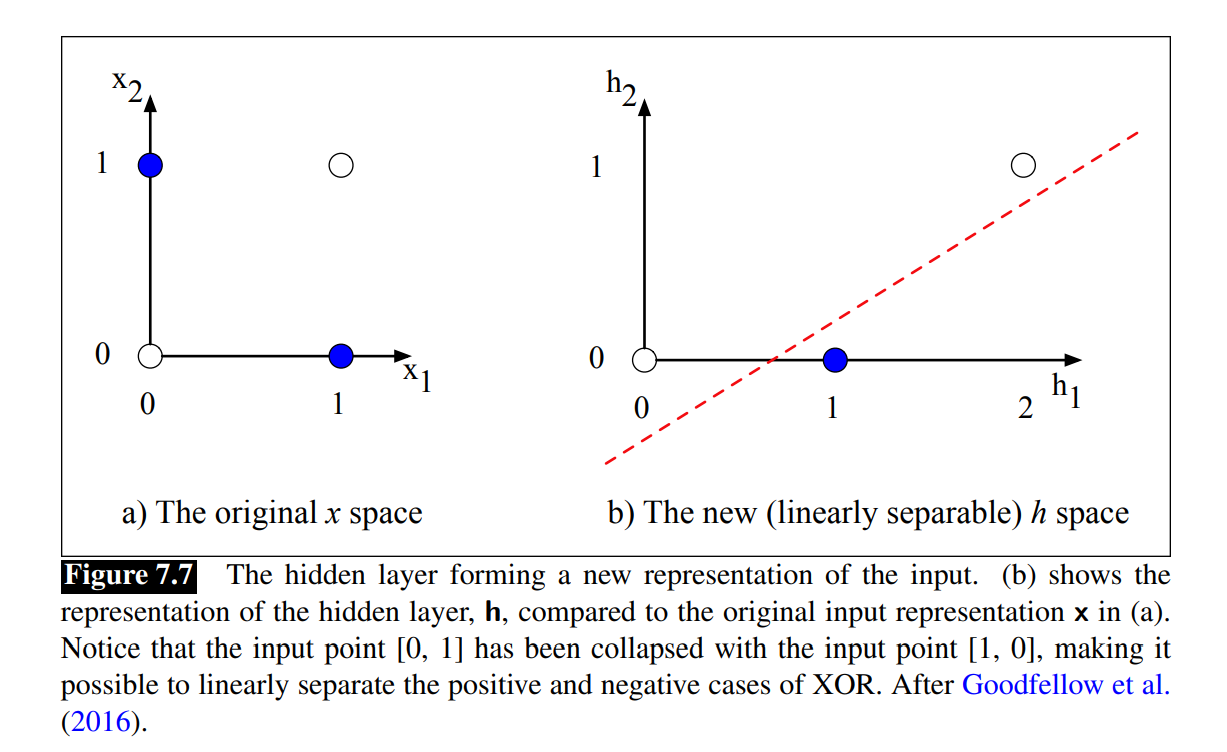

# Закатываем рукава и пишем классификатор

### 1. Бинарная классификация

- Бейзлайн: Логрег
- tf-idf + пара слоев
- word2vec + пара слоев 

#### Данные: грузим, смотрим. Опоционально, чистим.

In [7]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"\b\d+\b", "", text)
    return text

In [8]:
# удалили пустые значения
df_toxic_bin = pd.read_csv('bin_toxic.csv').dropna()
# скастовали тип лейбла в инт
df_toxic_bin['toxic'] = df_toxic_bin['toxic'].astype(int)
# вычистили токены-числа
df_toxic_bin['comment'] = df_toxic_bin['comment'].apply(preprocess)
df_toxic_bin = df_toxic_bin[df_toxic_bin['comment'] != ''].reset_index(drop=True)
df_toxic_bin[10:]

,comment,toxic
10,"зачем ты пишешь хуйню, дегенерат? поцелуй в гу...",1
11,"бактерия, тебе этого не понять конечно, я же н...",1
12,"почитайте посты у этого автора,может найдете ч...",0
13,уроды!! у нас в семье поколения там родились\n,1
14,можем на тебя ещё и модера за безмозглых позва...,1
...,...,...
14407,вонючий совковый скот прибежал и ноет. а вот и...,1
14408,а кого любить? гоблина тупорылого что-ли? или ...,1
14409,"посмотрел утомленных солнцем . и оказалось, чт...",0
14410,крымотред нарушает правила раздела т.к в нем н...,1


In [9]:
df_toxic_bin['toxic'].value_counts()

toxic
0    9586
1    4826
Name: count, dtype: int64

In [10]:
train_data, test_data = train_test_split(df_toxic_bin, test_size=0.2, random_state=SEED)
train_data

,comment,toxic
3424,тут проблема - где критерии и границы? кто-то ...,0
11493,"будешь нарушать, долго не продержишься.\n",1
8311,не настолько все плохо с районом от центра мин...,0
4989,а давайте бросать вместе. как раз понедельник\n,1
500,а ты гей-геронтофил )\n,1
...,...,...
5378,"ага, в сериале как избежать наказание за убийс...",0
4412,ха-ха-ха! я смеюсь в лицо оскорбляющим меня!\n,1
13779,"израиль. спецподразделения армии, полиции и ша...",1
4149,"бля, то, что раньше было обычным делом, сейчас...",0


In [11]:
test_data

,comment,toxic
4557,"так же про свой город могу сказать, но все рав...",0
6488,выглядит не хуже моей уральской дыры. таких до...,0
4835,"разбираем аппарат, смотрим модель матрицы. ище...",0
8067,"ну вообще нет, или тогда и офис должен быть вк...",0
919,"взять того же just илью. мож он и норм, но кол...",1
...,...,...
1258,"скажи спасибо, что они забыли про ее грудь",0
8190,"к сожалению, у людей ограничен объем знаний. д...",0
7356,и жили они долго и счастливо пока не умерли в ...,0
11915,зарплаты.(чуть меньше на самом деле) а можно ...,0


#### Бейзлайн: логрег

In [12]:
# Перво-наперво, насчитаем себе фич для слов:

# TF-IDF, стырено у Ники
tfidf_vec = TfidfVectorizer(max_features=6000)
vecs_train_tfidf = tfidf_vec.fit_transform(train_data['comment']).toarray()
vecs_test_tfidf = tfidf_vec.transform(test_data['comment']).toarray()

vecs_train_tfidf.shape, vecs_test_tfidf.shape


((11529, 6000), (2883, 6000))

In [13]:
tfidf_vec.get_feature_names_out()[:300]

array(['100к', '10к', '1с', '20к', '2к', '300к', '30к', '3d', '3х', '40к',
       '4х', '500к', '50к', '5к', '60к', '70к', '90е', '90х', 'boeing',
       'facebook', 'gifx', 'https', 'imei', 'ip', 'iphone', 'is', 'it',
       'mail', 'of', 'phd', 'ru', 's8', 'samsung', 'souls', 'the', 'usb',
       'windows', 'www', 'xd', 'yota', 'абсолютно', 'абу', 'аварии',
       'аватаркой', 'августа', 'августе', 'авиакомпании', 'авто',
       'автобус', 'автобусе', 'автоматически', 'автоматом', 'автомобили',
       'автомобиль', 'автомобиля', 'автор', 'автора', 'автору', 'ага',
       'агентство', 'адекватные', 'администрации', 'администрация',
       'адрес', 'аду', 'аж', 'азии', 'ай', 'аймак', 'айфон',
       'аккумулятор', 'аккуратно', 'активно', 'активности', 'активных',
       'акции', 'але', 'александр', 'али', 'алкоголь', 'алкоголя',
       'аллергия', 'алсо', 'американской', 'американцы', 'америке', 'ан',
       'анализ', 'аналог', 'аналогично', 'англии', 'анекдот', 'аниме',
       'анон',

In [14]:
clf_tfidf = LogisticRegression()
clf_tfidf.fit(vecs_train_tfidf, train_data['toxic'])

preds = clf_tfidf.predict(vecs_test_tfidf)
# print(len(preds))
print(classification_report(test_data['toxic'], preds))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1939
           1       0.87      0.58      0.70       944

    accuracy                           0.84      2883
   macro avg       0.85      0.77      0.79      2883
weighted avg       0.84      0.84      0.83      2883



#### Теперь напишем маленькую сетку

Но сперва нужно озаботиться тем, как мы будем подавать данные в модель

In [15]:
class TinyModel(nn.Module):

    def __init__(self, n_inputs, n_outputs):
        # инициализация родителя
        super().__init__()
        # линейный слой, он же полносвязный
        self.linear = torch.nn.Linear(n_inputs, n_outputs)

    # нам надо расписать forward проход (т.е. когда данные проходят к output'у)
    def forward(self, x):
        # print(type(input))
        y_pred = self.linear(x)
        return y_pred
    
    # бэквард выводится автоматически

In [16]:
# входная размерность - размер словаря тф-идф
input_dim = vecs_train_tfidf.shape[1]
# классификация бинарная
output_dim = 2
model = TinyModel(input_dim, output_dim)


# достаем из коробки лосс
criterion = nn.CrossEntropyLoss()
# достаем оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.01)


# ВАЖНО: переносим обучение на видеокарту если такая есть
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X = torch.tensor(vecs_train_tfidf, dtype=torch.float32).to(device)
y = torch.tensor(train_data['toxic'].to_list(), dtype=torch.long).to(device)


А как мы тогда подаем данные? Тут появляется такое понятие, как **батчинг**. 

Батч - это подмножество примеров, которое обрабатывается моделью одновременно, за раз.

Батчи это хорошо. Почему?

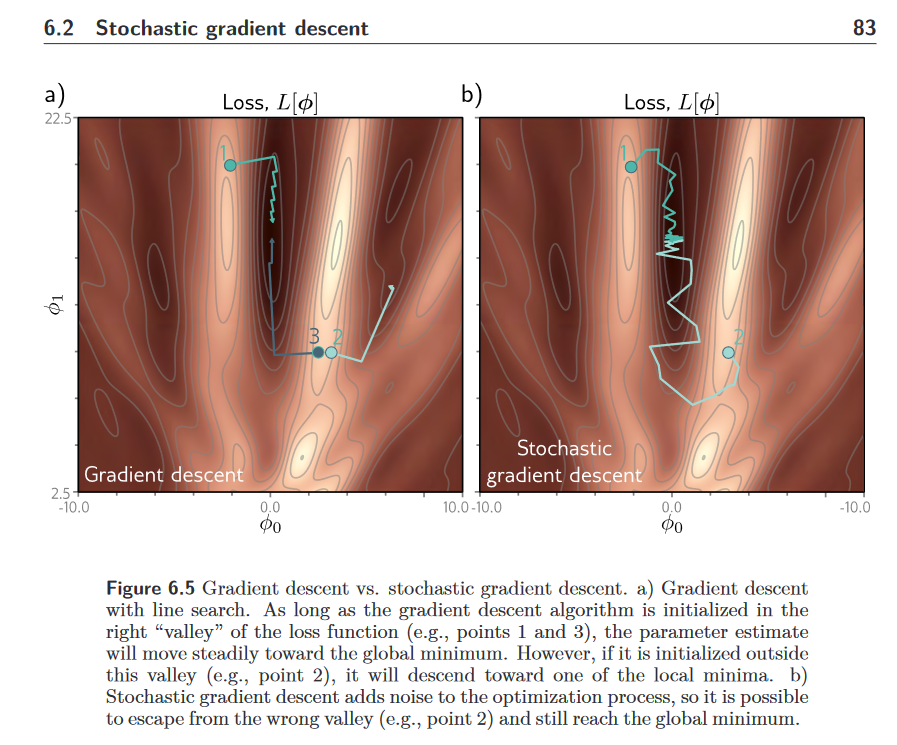


##### ^^ Летнешкольник ищет место, где лучше ловит

In [17]:

# Руками их с нуля никто их не пишет не бойтесь
class SimpleDataLoader():
    def __init__(self, data, labels, batch_size=4, shuffle=True):
        # инициализируем параметры
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

        # достаем индексы отдельно, чтобы их перемешивать
        self.num_samples = len(data)
        self.indices = list(range(self.num_samples))
        self.current_index = 0
        # перемешиваем
        if self.shuffle:
            random.shuffle(self.indices)

    # вызывается в начале цикла (и эпохи) (неявно), обнуляет индекс и снова перемешивает
    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)
        self.current_index = 0
        return self
    
    # вызывается на каждой итерации, возвращает очередной батч
    def __next__(self):
        if self.current_index >= self.num_samples:
            raise StopIteration
        
        end_index = self.current_index + self.batch_size
        if end_index >= self.num_samples:
            end_index = self.num_samples
        # print(self.current_index)
        # print(self.current_index + self.batch_size)
        batch_indices = self.indices[self.current_index:end_index]
        batch_texts = [np.array(self.data[i]) for i in batch_indices]
        batch_texts = torch.tensor(batch_texts, dtype=torch.float32)
        batch_labels = [self.labels[i] for i in batch_indices]
        batch_labels = torch.tensor(batch_labels,dtype=torch.long)
        self.current_index += self.batch_size
        return batch_texts, batch_labels

In [18]:
data = torch.tensor(vecs_train_tfidf)
print(vecs_train_tfidf.shape)
label = torch.tensor(train_data['toxic'].to_list())
print(len(data))
print(len(label))

(11529, 6000)
11529
11529


In [19]:
# %debug
X = torch.tensor(vecs_test_tfidf, dtype=torch.float32)
y = torch.tensor(test_data['toxic'].to_list(), dtype=torch.long)

dataloader = SimpleDataLoader(data, label, batch_size=8, shuffle=True)
epochs = 1
for epoch in range(epochs):
    for inputs, labels in tqdm(dataloader):
        
        optimizer.zero_grad()
        outputs = model(inputs)

        # print(outputs)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y).sum().item() / y.size(0)
    print(f'Accuracy Epoch {epoch+1}: {accuracy}')

0it [00:00, ?it/s]C:\Users\Elena\AppData\Local\Temp\ipykernel_844\2179313260.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  batch_texts = torch.tensor(batch_texts, dtype=torch.float32)
1442it [00:32, 43.79it/s]

Epoch 1, Loss: 1.201723337173462
Accuracy Epoch 1: 0.8463406174124176


In [20]:
# Evaluate the model
X = torch.tensor(vecs_test_tfidf, dtype=torch.float32)
y = torch.tensor(test_data['toxic'].to_list(), dtype=torch.long)


with torch.no_grad():
    outputs = model(X)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y).sum().item() / y.size(0)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8463406174124176


А если мы захотим прогнать модель на каких-то своих данных, как это писать?

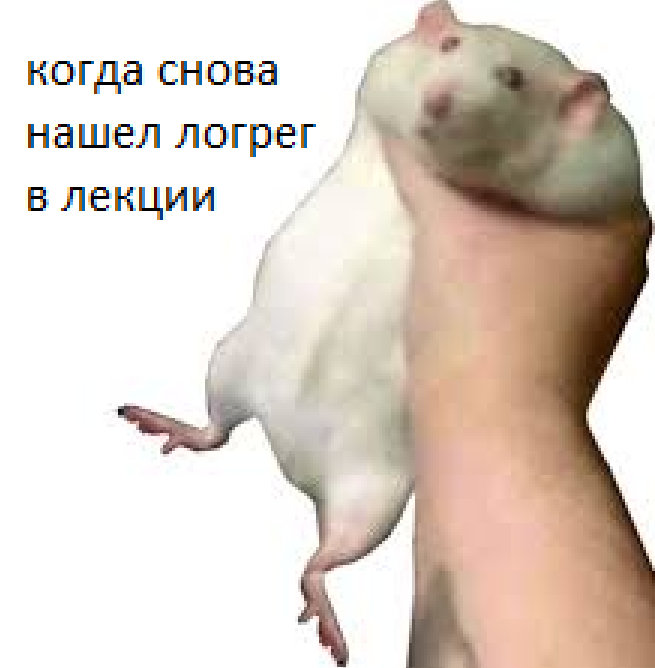

### А теперь серьезно.
# Переобучение

### Что такое переобучение? Где здесь переобучение?

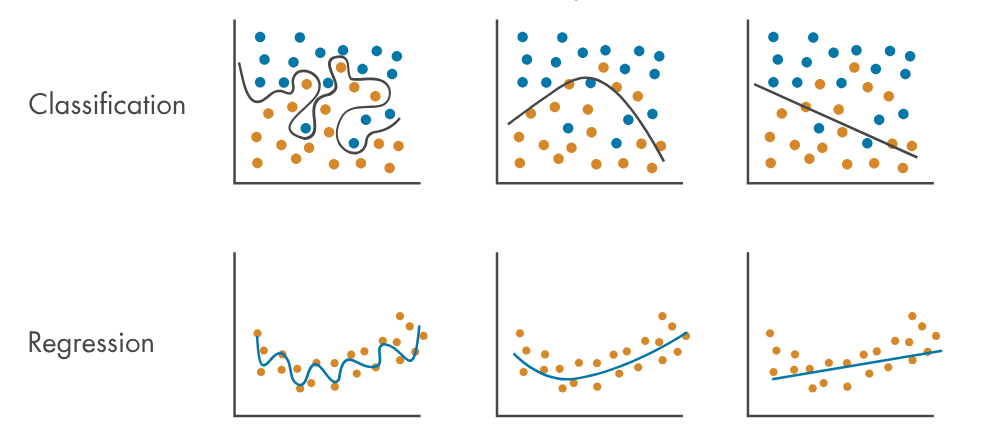

### Давайте переобучим модель!
Что для этого нужно?

### Слишком большая модель

In [21]:
class BigModel(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_inputs, 1000)
        self.fc2 = torch.nn.Linear(1000, 600)
        self.fc3 = torch.nn.Linear(600, n_outputs)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        y_pred = self.fc3(x)
        return y_pred


In [22]:
def train_loop(dataloader, model, optimizer, criterion, epochs):
    for epoch in range(epochs):
        for inputs, labels in tqdm(dataloader):
            
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        with torch.no_grad():
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y).sum().item() / y.size(0)
        print(f'Accuracy Epoch {epoch+1}: {accuracy}')

In [23]:
model = BigModel(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(device)

train_loop(dataloader, model, optimizer, criterion, epochs=1)

1442it [04:49,  4.97it/s]


Epoch 1, Loss: 0.03581857681274414
Accuracy Epoch 1: 0.8335067637877211



- А почему мы в принципе не переобучаемся на нескольких эпохах **вообще всегда**?

# Регуляризация

#### Регуляризация в целом

In mathematics, statistics, finance,[1] and computer science, particularly in machine learning and inverse problems, regularization is a process that changes the result answer to be "simpler". It is often used to obtain results for ill-posed problems or to prevent overfitting.[2] -- Wikipedia

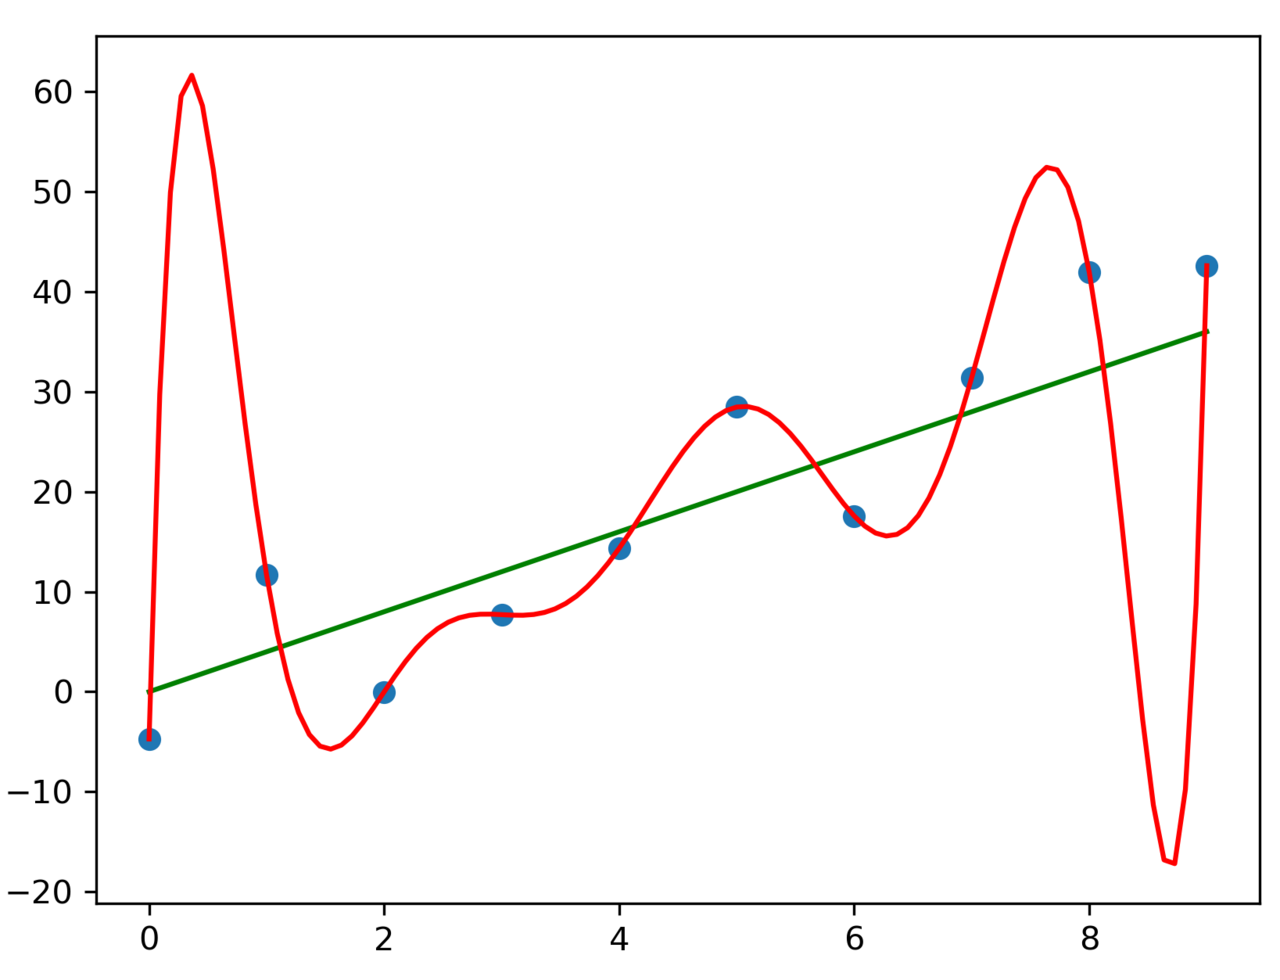

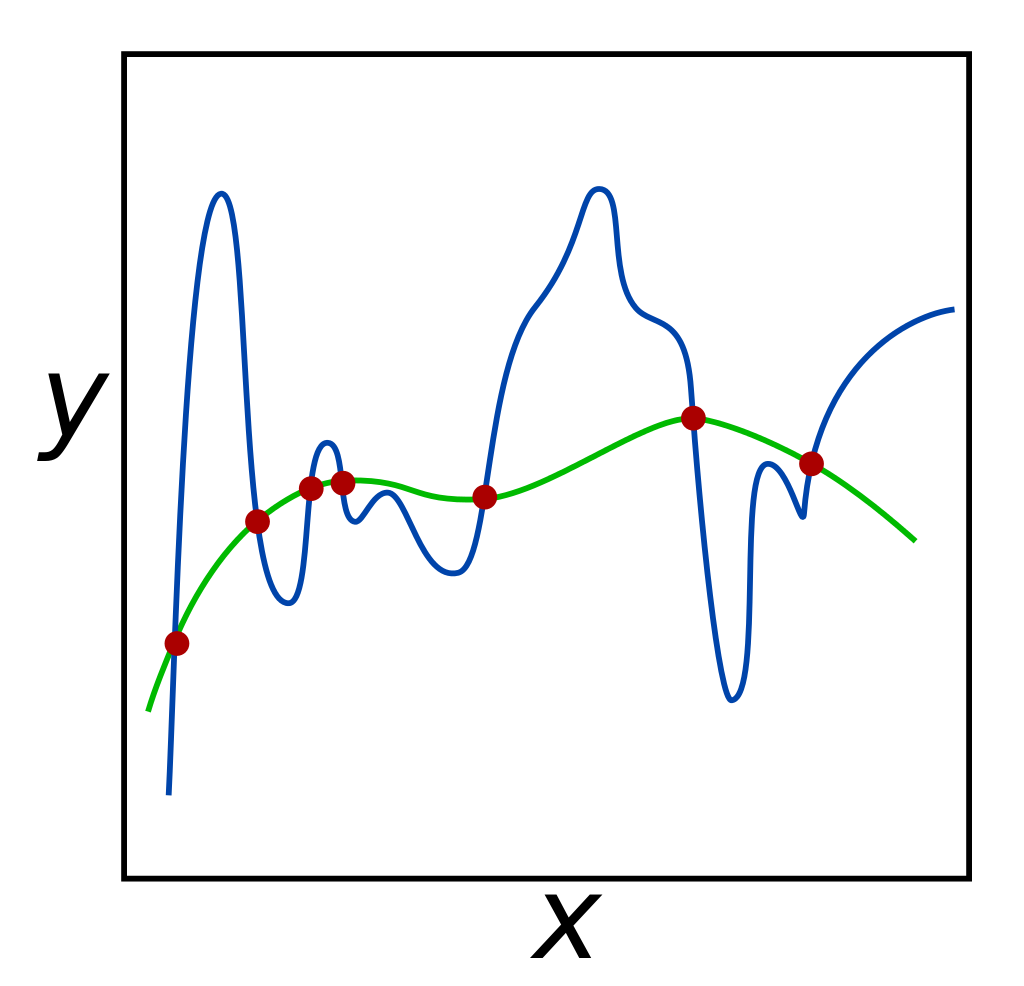

^^ Два вида переобучения: слишком подогнались под шумные данные и никак не ограничили функцию там, где данных нет 

По книжке *Understanding Deep Learning*:

Три типа регуляризации:
- Явный, когда мы дописываем в лосс штрафы (за слишком большие веса)
- Неявный: сам градиентный спуск немного регуляризует
- Эвристики!

Несколько картинок, которые иллюстрируют регуляризацию (явную):

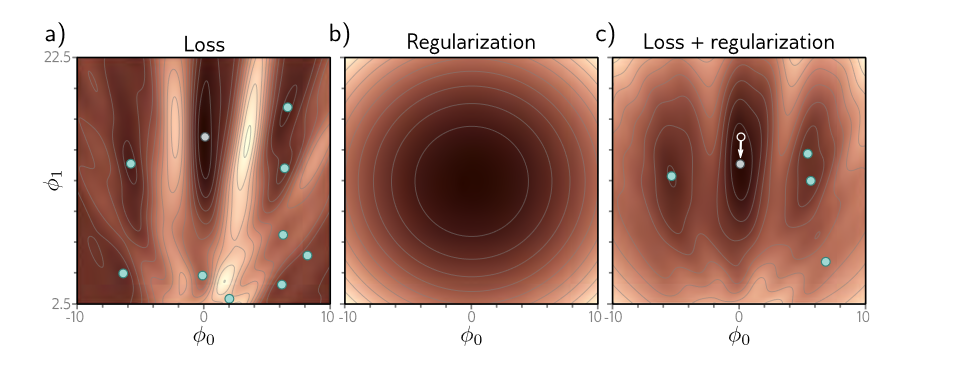

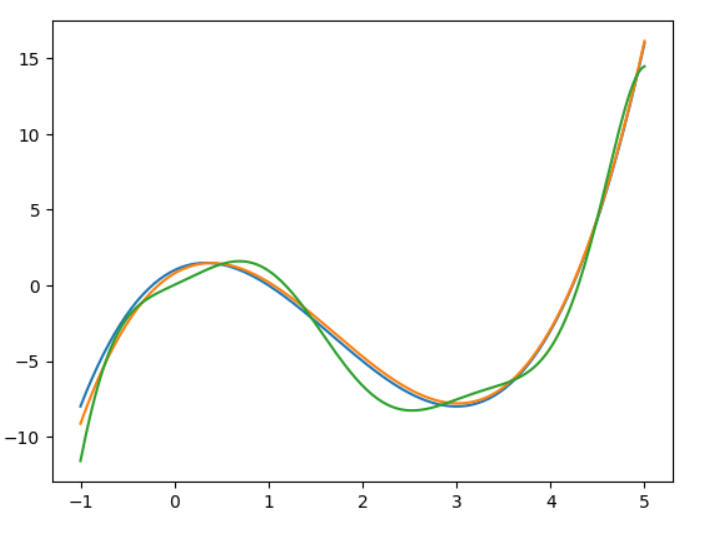

### Регуляризация в нейросетях

##### Явная
*For neural networks, L2 regularization is usually applied to the weights but not the biases and is hence referred to as a weight decay term. The effect is to encourage smaller weights, so the output function is smoother. To see this, consider that the output prediction is a weighted sum of the activations at the last hidden layer. If the L2 regularization weights have a smaller magnitude, the output will var less* -- **Веса модели можно явно регуляризовать Ridge-регуляризацией**


(When the network is over-parameterized, some of the extra model capacity describes areas with no training data. Here, the regularization term will favor functions that smoothly interpolate between the nearby points. This is reasonable behavior in the absence of knowledge about the true function.)

##### Эвристики (не все)

- Early Stopping - ранняя остановка;
- Ансамблирование - очень успешно, кстати, еще используется, например, с решающими деревьями, которые любят переобучаться;
- **ДРОПАУТ** - отбрасывание??? Мы на каждой итерации насильно зануляем выход от части нод;
- **Transfer Learning** - выучили какое-то хорошее представление на другом домене (задаче), где данных много-много, потом адаптируем под наш. Часто делается посредством замораживания весов в backbone'е модели и тренировке новой головы. 

### Dropout

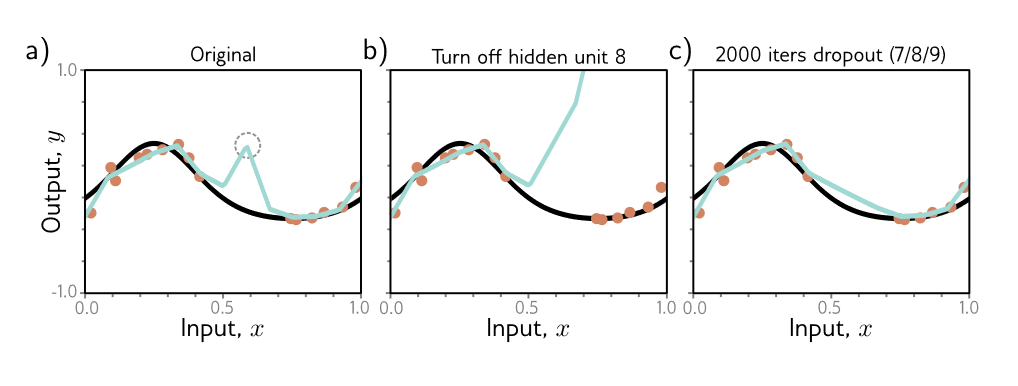

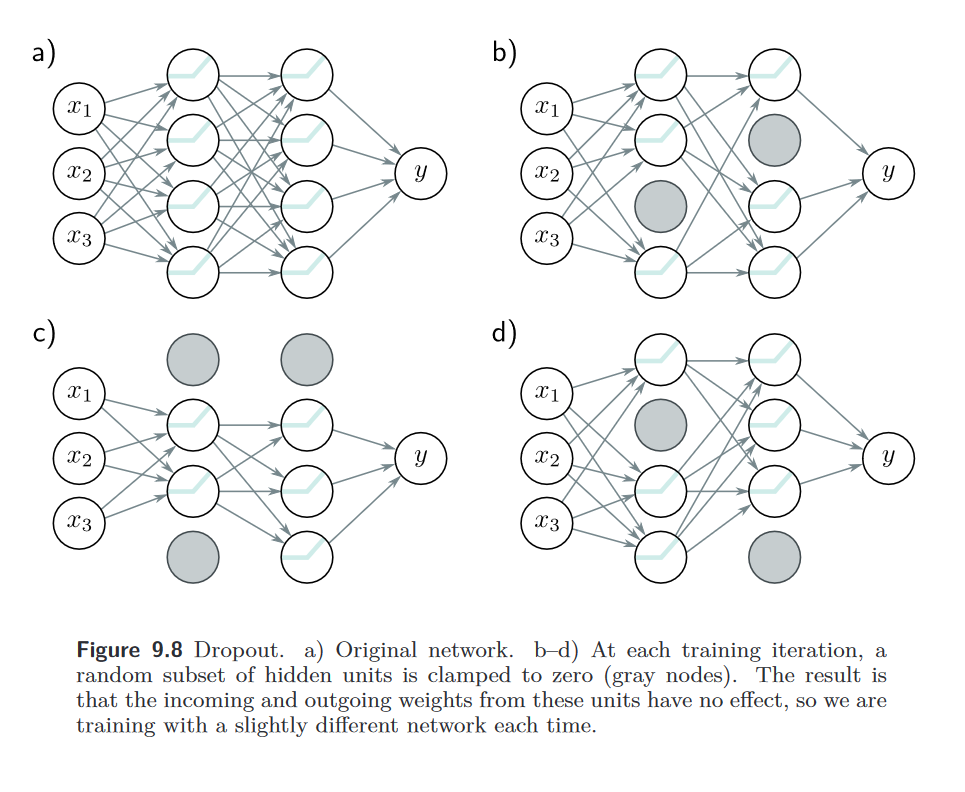

- Изначально был позиционирован как способ избавиться от групп нейронов, которые обучились компенсировать ошибки соседей;
- *"So training a neural network with dropout can be seen as training a collection of 2^n thinned networks with extensive weight sharing, where each thinned network gets trained very rarely, if at all.“ Dropout: A Simple Way to Prevent Neural Networks from Overfitting"*
- Классически называют dropout rate = 0.5 для скрытых слоев и 0.2 для входного;
- Dropout rate соответственно уменьшает значения передаваемые по сети, поэтому на инференсе (этапе тестирования, использования, НЕ обучения) нужно умножать веса на соответствующее значение;
- Отдельный класс в торче.
- Почему просто не использовать модель поменьше вместо дропаута? Ответ: https://datascience.stackexchange.com/questions/57267/why-use-regularization-instead-of-decreasing-the-model

### Transfer Learning, Feature Learning и эмбеддинги

Мы берем какие-то данные, которых много. Мы учим на них что-то, получаем какую-то предобученную модель или список фич. Потом мы можем использовать это для какой-то другой задачи. **Похоже на что-то?**

# Пишем классификатор "как надо"

### Добавим Dropout

In [24]:
class NNModel(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_inputs, 400)
        self.fc2 = torch.nn.Linear(400, 200)
        self.fc3 = torch.nn.Linear(200, n_outputs)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        y_pred = self.fc3(x)
        return y_pred


In [25]:
model = NNModel(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(device)

train_loop(dataloader, model, optimizer, criterion, epochs=1)

1442it [02:14, 10.72it/s]


Epoch 1, Loss: 0.08047928661108017
Accuracy Epoch 1: 0.8380159556018036


### Теперь эмбеддинги!

Тут немного перекладывания векторов из w2v модели и данных, чтобы их не чистить потом. Особой образовательной ценности уже не несет, но пусть будет.

In [26]:
# fasttext_path = 'toxic_model.bin'

# w2v = KeyedVectors.load('toxic_model')

# print(f"Number of words in FastText model: {len(w2v.key_to_index)}")
# print(f"Embedding dimension: {w2v.vector_size}")

In [27]:
# w2v['бугурт']

In [28]:
# vocab = set(w2v.key_to_index.keys())

In [29]:
# from nltk import word_tokenize

# def filter_dataframe(df, column_name, vocab):
#     def contains_vocab_word(text):
#         words = word_tokenize(text)  # Assuming the text is a string of words separated by spaces
#         return any(word in vocab for word in words)
    
#     filtered_df = df[df[column_name].apply(contains_vocab_word)]
#     return filtered_df

In [30]:
# print(len(vocab))

In [31]:
# train_data = filter_dataframe(train_data, 'comment', vocab)
# test_data = filter_dataframe(test_data, 'comment', vocab)

In [32]:
# train_data

In [33]:
# test_data

In [34]:
# validation_data

NameError: name 'validation_data' is not defined

In [ ]:
train_data.to_csv('train_data.csv')
validation_data.to_csv('validation_data.csv')
test_data.to_csv('test_data.csv')


# Источники

1. https://web.stanford.edu/~jurafsky/slp3/ -- Speech and Language Processing (3rd ed. draft)
Dan Jurafsky and James H. Martin
2. https://udlbook.github.io/udlbook/ -  Understanding Deep Learning, Simon J.D. Prince - Замечательная книга, очень рекомендую